In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression

### Define Dimensions

* we choose an underdetermined where N << d

In [502]:
N = 20
d = 25

### Define Dataset

* to make sure the data is realizable by a linear model we create the y using a fitter linear regressor.

* the regressor is chosen to have positive coefficients and no intercept to simulate our u^2 model.

In [503]:
x = np.random.normal(size=(N, d))
y_inital = np.zeros((N,))    # this is just a place-hold for the shape of y

In [504]:
reg = LinearRegression().fit(x, y_inital)
reg.coef_ = np.random.random(size=(d,))   # set positive coefficients only

In [505]:
y = reg.predict(x)

### Define Gradient Decent

* $r_n(t) = \mathbf{X}^T \cdot \mathbf{u}^2(t) - y$

* $\dot{\mathbf{u}_i}(t) = - \mathbf{u}_i(t) \sum_n x_{n, i} r_n(t)$

* $L(u) = \frac12 \sum_n r_n(t)^2$

In [471]:
def update(u, x, y, step_size):
    r = np.dot(x, u**2) - y
    grad_u = - np.multiply(np.dot(x.transpose(), r), u)
    u = u + step_size * grad_u
    loss = 0.5 * np.sum(r**2)
    return u, loss

### Define Q

* $q(z) = \frac{z \cdot (ln(z) - 1)}{2}$
* $Q(w) = \sum_{i \in [d]} w_i(0) \cdot q(\frac{w_i}{w_i(0)})$

In [472]:
def q_func(x):
    return 0.5 * x * (np.log(x) - 1)

In [473]:
def Q_func(w, w_0):
    f = 0
    for w_i, w_0_i in zip(w, w_0):
        f += w_0_i * q_func(w_i / w_0_i)
    return f

In [474]:
def solver(x, y, w_0, obj='L1', optim_tol=1e-6, x0=None):
    if x0 is None:
        x0 = w_0
        
    cons = {'type': 'eq', 'fun': lambda w: np.dot(x, w) - y}

    if obj == 'L1':
        objective = lambda w: np.linalg.norm(w, ord=1)
    elif obj == 'minus_L1':
        objective = lambda w: - np.linalg.norm(w, ord=1)
    elif obj == 'Q':
        objective = lambda w: Q_func(w, w_0)
    else:
        raise ValueError('objective not supported.')
    
    sol = minimize(
        fun=objective,
        x0=x0,
        constraints=cons,
        tol=optim_tol,
        method='SLSQP',
        options={
            'maxiter': 100000,
            'disp': True
        },
        bounds=[(1e-10, np.infty)] * len(w_0)  # to keep the input to Q positive.
    )
    is_failed = (not sol.success)
    if is_failed:
        raise RuntimeError('Minimization Failed.')

    return sol.x

### Find L1 solution

In [506]:
u_0 = np.random.normal(size=(d,))
w_0 = u_0**2

In [507]:
w_opt_L1 = solver(x, y, w_0, obj='L1', optim_tol=1e-5)

minimal_L1 = np.linalg.norm(w_opt_L1, ord=1)
minimal_L1

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 12.5840316375154
            Iterations: 6
            Function evaluations: 162
            Gradient evaluations: 6


12.5840316375154

In [508]:
loss = 0.5 * np.sum((np.dot(x, w_opt_L1) - y)**2)
loss

8.085412996844883e-16

In [509]:
w_opt_minus_L1 = solver(x, y, w_0, obj='minus_L1', optim_tol=1e-5)

maximal_L1 = np.linalg.norm(w_opt_minus_L1, ord=1)
maximal_L1

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -18.889423734369352
            Iterations: 6
            Function evaluations: 162
            Gradient evaluations: 6


18.889423734369352

### Run GD

* check GD solutions at high / low $\alpha$ values where:
* $u_0 \sim{}  N(0, \alpha)$ 

In [479]:
def run_GD(u_0, n_epochs, step_size): 
    u = np.array(u_0)

    for epoch in range(n_epochs):
        u, loss = update(u, x, y, step_size)
        
    L1 = np.linalg.norm(u**2, ord=1)
    return L1, u, loss

In [480]:
u_0 = np.random.normal(size=(d,), loc=0, scale=1e-6)  

L1, u, loss = run_GD(u_0=u_0, n_epochs=10000, step_size=0.01)
L1, loss

(9.963644472008074, 0.07079035761211727)

In [481]:
u_0 = np.random.normal(size=(d,), loc=0, scale=100)  

L1, u, loss = run_GD(u_0=u_0, n_epochs=10000, step_size=0.001/100**2)
L1, loss

(21439.673887101188, 3522876.0600530854)

In [486]:
excess_L1_GD = []
excess_maximal_L1_GD = []
loss_GD = []

alpha_range = [1e-6, 1e-3, 1e-2, 1e-1, 0.5, 1, 2.5, 10, 1e2, 1e3, 1e5]

for alpha in alpha_range:
    u_0 = np.random.normal(size=(d,), loc=0, scale=alpha)   
    w_0 = np.array(u_0**2)
   
    L1,  u, loss = run_GD(u_0=u_0, n_epochs=100000, step_size=0.001/max(0.1, alpha**2))
    excess_L1_GD.append(L1 - minimal_L1)
    excess_maximal_L1_GD.append(maximal_L1 - L1)
    loss_GD.append(loss)

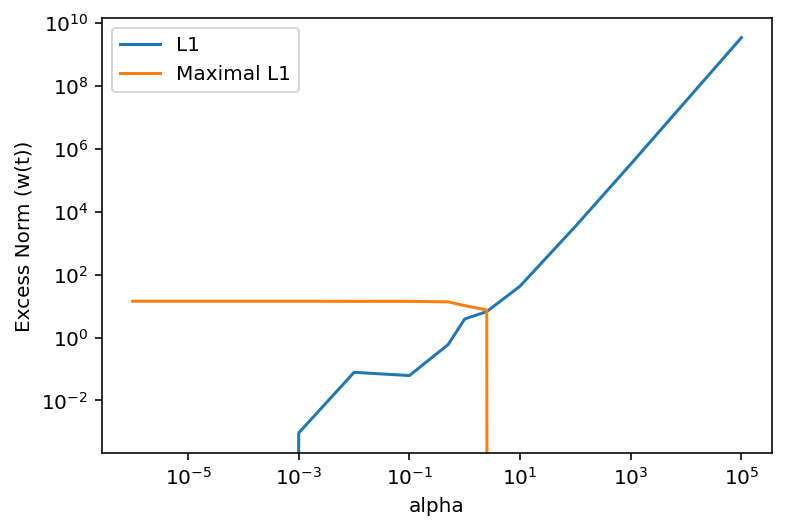

In [487]:
plot(alpha_range, excess_L1_GD)
plot(alpha_range, excess_maximal_L1_GD)
yscale('log')
xscale('log')
xlabel('alpha')
ylabel('Excess Norm (w(t))')
legend(['L1', 'Maximal L1'])

In [488]:
loss_GD

[1.9134129404926743e-27,
 8.440688426348386e-28,
 4.885883972196201e-28,
 3.0204744503813897e-28,
 2.5835518202218794e-27,
 1.8171411456537285e-18,
 3.8501636919284436e-07,
 4.384162270965607,
 77054.71065614224,
 692850000.9112918,
 7.533604634509318e+16]

In [489]:
excess_maximal_L1_GD

[14.172885301433771,
 14.171955613334417,
 14.094728680927208,
 14.11096888518488,
 13.578727183524407,
 10.286721493421714,
 7.523150110966306,
 -28.80356377443203,
 -3387.958694729387,
 -323698.7703081937,
 -3380031919.3548603]

### Compare Q to GD

In [187]:
L1_GD = []
L2_GD = []
loss_GD = []
L1_Q = []
L2_Q = []
loss_Q = []

alpha_range = [1e-2, 1e-1, 0.5, 1, 10, 1e2]

for alpha in alpha_range:
    u_0 = np.random.normal(size=(d,), loc=0, scale=alpha)   
    w_0 = np.array(u_0**2)

    w_opt_Q = solver(x, y, w_0, obj='Q', optim_tol=1e-3)
    
    loss_Q.append(0.5 * np.sum((np.dot(x, w_opt_Q) - y)**2))
    L1_Q.append(np.linalg.norm(w_opt_Q, ord=1))
    L2_Q.append(np.linalg.norm(w_opt_Q, ord=2))
    
    L1, L2, u, loss = run_GD(u_0=u_0, n_epochs=10000, step_size=0.001/max(0.01, alpha**2))
    L1_GD.append(L1)
    L2_GD.append(L2)
    loss_GD.append(loss)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 9.874228002947541
            Iterations: 9
            Function evaluations: 279
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7.078155481489701
            Iterations: 4
            Function evaluations: 128
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2.0202970356027716
            Iterations: 16
            Function evaluations: 449
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8.743194295582054
            Iterations: 22
            Function evaluations: 612
            Gradient evaluations: 22
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -759.4331814469699
            Iterations: 49
            Function

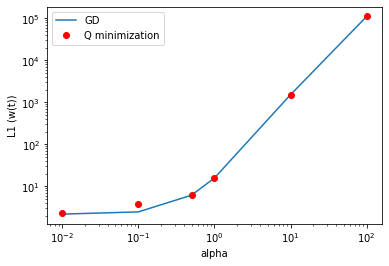

In [188]:
plot(alpha_range, L1_GD);
plot(alpha_range, L1_Q, 'ro');
yscale('log')
xscale('log')
xlabel('alpha')
ylabel('L1 (w(t))')
legend(['GD', 'Q minimization'])

In [189]:
loss_GD

[2.389116096012366e-31,
 2.1580045026858978e-31,
 6.499628376318044e-29,
 1.1256109115550866e-27,
 1.9962060571253212e-23,
 1.6590079120968658e-19]

In [190]:
loss_Q

[9.857151368677916e-17,
 6.488817651702231e-16,
 9.014339193142668e-20,
 1.1473077632132885e-18,
 4.1104764112116337e-13,
 6.323033789432937e-08]

### Compare Q and Minus L1

In [510]:
alpha_range = [1, 10, 1e2, 1e3, 1e5, 1e7]

euc_dist = []
for alpha in alpha_range:
    u_0 = np.random.normal(size=(d,), loc=0, scale=alpha)   
    w_0 = np.array(u_0**2)
    
    w_opt_Q = solver(x, y, w_0, obj='Q', optim_tol=1e-3, x0=[0] * len(w_0))  
    euc_dist.append(sum((w_opt_Q - w_opt_minus_L1)**2))

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2.2956791592603576
            Iterations: 4
            Function evaluations: 120
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -44.54223266135092
            Iterations: 3
            Function evaluations: 95
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -85.66443275300995
            Iterations: 2
            Function evaluations: 63
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -122.95139400755545
            Iterations: 7
            Function evaluations: 195
            Gradient evaluations: 7
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -214.03978629583395
            Iterations: 2
            Function ev

Text(0, 0.5, 'Euc distance')

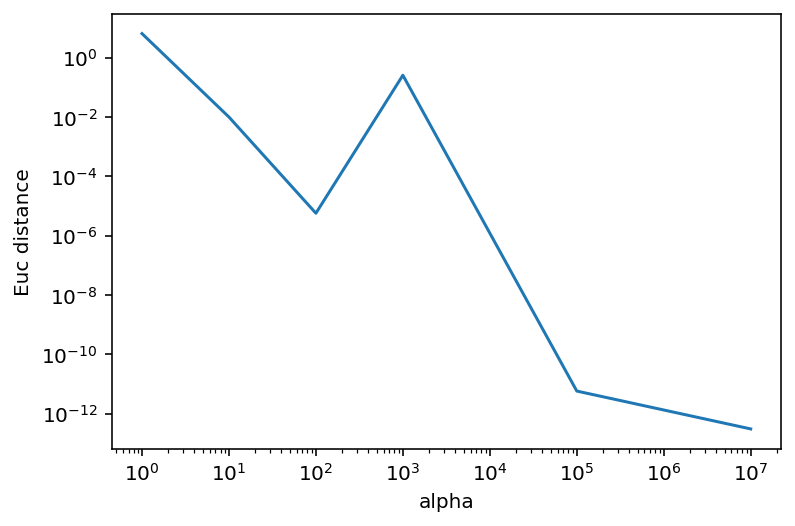

In [516]:
plot(alpha_range, euc_dist)
yscale('log')
xscale('log')
xlabel('alpha')
ylabel('Euc distance')

In [512]:
w_opt_Q

array([7.34744298e-01, 9.72888631e-01, 1.56852173e+00, 1.43479920e+00,
       5.25366792e-01, 9.44220933e-01, 1.05449790e+00, 6.42810922e-01,
       1.76769422e+00, 4.68994738e-01, 1.12547759e+00, 8.08740321e-04,
       5.47416046e-01, 4.97958651e-01, 9.52560686e-09, 1.00000000e-10,
       1.16977812e+00, 1.35395406e+00, 1.02401703e-10, 4.89873183e-08,
       1.50151101e+00, 1.18235215e+00, 6.04404269e-01, 7.91222759e-01,
       1.00000000e-10])

In [513]:
w_opt_minus_L1

array([7.34744229e-01, 9.72888672e-01, 1.56852182e+00, 1.43479927e+00,
       5.25366965e-01, 9.44221006e-01, 1.05449788e+00, 6.42810968e-01,
       1.76769436e+00, 4.68994713e-01, 1.12547756e+00, 8.08844498e-04,
       5.47416101e-01, 4.97958404e-01, 1.00017314e-10, 1.00001530e-10,
       1.16977806e+00, 1.35395438e+00, 1.00003853e-10, 1.00023628e-10,
       1.50151101e+00, 1.18235232e+00, 6.04404285e-01, 7.91222888e-01,
       1.00002822e-10])